In [1]:
import requests
import sqlite3
import pandas as pd

# connect to the DB
conn = sqlite3.connect('C:/Users/Mark Rozenberg/Foobal-Climate/Data/Main_DB.db')

In [ ]:
df = pd.read_sql_query('''
with part1 as (
select date, home_team, away_team, home_score, away_score, tournament, city, country, neutral,
case
when avg_tavg is not null then round(avg_tavg, 1)
when avg_tavg is null and avg_tmax is not null and avg_tmin is not null then round((avg_tmax + avg_tmin) / 2, 1)
when avg_tavg is null and avg_tmax is null and avg_tmin is not null then round(avg_tmin, 1)
when avg_tavg is null and avg_tmax is not null and avg_tmin is null then round(avg_tmax, 1)
else null end as temperature,
coalesce(avg_prcp, 0) as precipitation,
coalesce(avg_snow, 0) as snow
from results
where location_date_id is not null
)
select *,
home_score + away_score as total_goals,
case
when temperature < 0 then 'Freezing'
when temperature >= 0 and temperature < 10 then 'Very_Cold'
when temperature >= 10 and temperature < 20 then 'Cold'
when temperature >= 20 and temperature < 30 then 'Warm'
when temperature >= 30 then 'Hot'
else 'Unknown' end as temperature_category,
case
when ratutempere < 10 then 'cold'
when temperature >= 10 and temperature < 30 then 'normal'
when temperature >= 30 then 'hot'
else 'Unknown' end as temperature_category_v2
from part1
where temperature is not null
''', conn)

In [33]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'temperature',
       'precipitation', 'snow', 'total_goals', 'temperature_category'],
      dtype='object')

In [58]:
df.groupby('temperature_category_v2').agg(
	cnt=('temperature_category', 'size'),
	total_goals=('total_goals', 'sum'),
	avg_goals=('total_goals', 'mean'),
	median_goals=('total_goals', 'median')
).reset_index().sort_values(by='temperature_category_v2', key=lambda x: x.map({'cold': 0, 'normal': 1, 'hot': 2}))

,temperature_category_v2,cnt,total_goals,avg_goals,median_goals
0,cold,3244,9640,2.971640,3.0
2,normal,17071,48269,2.827544,3.0
1,hot,995,2818,2.832161,3.0


In [61]:
df.groupby('temperature_category').agg(
	cnt=('temperature_category', 'size'),
	total_goals=('total_goals', 'sum'),
	avg_goals=('total_goals', 'mean'),
	median_goals=('total_goals', 'median')
).reset_index().sort_values(by='temperature_category', key=lambda x: x.map({'Freezing': 0, 'Very_Cold': 1, 'Cold': 2, 'Warm': 3, 'Hot': 4}))

,temperature_category,cnt,total_goals,avg_goals,median_goals
1,Freezing,189,518,2.740741,2.0
3,Very_Cold,3055,9122,2.985925,3.0
0,Cold,7994,22774,2.848887,3.0
4,Warm,9077,25495,2.808747,2.0
2,Hot,995,2818,2.832161,3.0


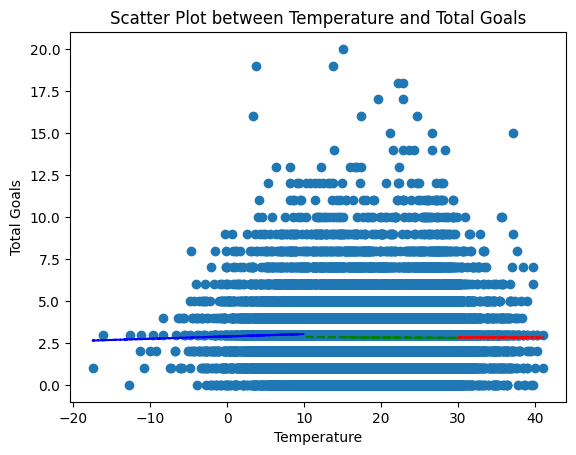

In [57]:
import matplotlib.pyplot as plt
import numpy as np
# Fit a linear trend line
z1 = np.polyfit(df[df['temperature'] < 10]['temperature'], df[df['temperature'] < 10]['total_goals'], 1)
p1 = np.poly1d(z1)
plt.plot(df[df['temperature'] < 10]['temperature'], p1(df[df['temperature'] < 10]['temperature']), "b--")

z2 = np.polyfit(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature'], df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['total_goals'], 1)
p2 = np.poly1d(z2)
plt.plot(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature'], p2(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature']), "g--")

z3 = np.polyfit(df[df['temperature'] >= 30]['temperature'], df[df['temperature'] >= 30]['total_goals'], 1)
p3 = np.poly1d(z3)
plt.plot(df[df['temperature'] >= 30]['temperature'], p3(df[df['temperature'] >= 30]['temperature']), "r--")
# z = np.polyfit(df['temperature'], df['total_goals'], 1)
# p = np.poly1d(z)
# plt.plot(df['temperature'], p(df['temperature']), "r--")
plt.scatter(df['temperature'], df['total_goals'])
plt.xlabel('Temperature')
plt.ylabel('Total Goals')
plt.title('Scatter Plot between Temperature and Total Goals')
plt.show()

## Research questions:
1. does temperature impact on the amount of goals scored per game
2. if a team plays away game with climate that differs significanlty from home, does it impacts on win rate

In [47]:
linear_model = smf.ols('total_goals ~ neutral + temperature_category_v2 + precipitation + snow + country', data=df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_goals   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.603
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           9.93e-95
Time:                        12:49:33   Log-Likelihood:                -44338.
No. Observations:               21310   AIC:                         8.898e+04
Df Residuals:                   21158   BIC:                         9.019e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [17]:
# Linear Regression
linear_model = smf.ols('total_goals ~ temperature + I(temperature**2)', data=df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_goals   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.719
Date:                Sun, 05 Jan 2025   Prob (F-statistic):            0.00329
Time:                        10:13:22   Log-Likelihood:                -44750.
No. Observations:               21310   AIC:                         8.951e+04
Df Residuals:                   21307   BIC:                         8.953e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.0132    

In [14]:
# Save the summary of the linear model to a CSV file
with open('linear_model_summary.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

# Save the summary of the Poisson model to a CSV file
with open('poisson_model_summary.csv', 'w') as f:
    f.write(poisson_model.summary().as_csv())

# Save the summary of the Negative Binomial model to a CSV file
with open('neg_binom_model_summary.csv', 'w') as f:
    f.write(neg_binom_model.summary().as_csv())

Feature Importances: {'temperature': 0.5265309793068765, 'precipitation': 0.4286619372654038, 'snow': 0.0003973255918100351, 'neutral': 0.0444097578359097}
Mean Squared Error: 4.2706472436039915
R^2 Score: -0.09394666043357836


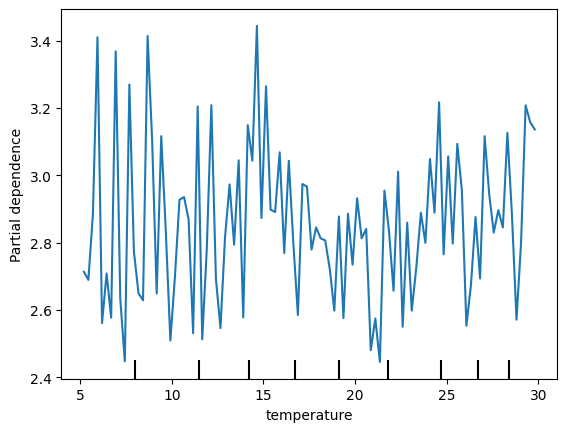

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Prepare the data
X = df[['temperature', 'precipitation', 'snow', 'neutral']]
y = df['total_goals']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Feature Importance
importances = rf_model.feature_importances_
print("Feature Importances:", dict(zip(X.columns, importances)))

# Step 4: Partial Dependence Plot
PartialDependenceDisplay.from_estimator(rf_model, X_train, ['temperature'])

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')